In [6]:
!pip install -q streamlit
!pip install mediapipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#dataset import
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files
files.upload()  #upload kaggle.json API file

!ls -lha kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle #Create the directory
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!pwd

# !kaggle datasets list
!kaggle datasets download -d grassknoted/asl-alphabet --force

!unzip asl-alphabet.zip


train = './content/asl-alphabet/asl-alphabet/train'
test = './content/asl-alphabet/asl-alphabet/test'

Mounted at /content/gdrive


Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [8]:

import streamlit as st
import mediapipe as mp
import cv2
import numpy as np
import tempfile
import time
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils


DEMO_VIDEO = 'demo.mp4'
DEMO_IMAGE = 'demo.jpg'

my_list = []




st.markdown(
    """
    <style>
    [data-testid="stSidebar"][aria-expanded="true"] > div:first-child {
        width: 350px;
    }
    [data-testid="stSidebar"][aria-expanded="false"] > div:first-child {
        width: 350px;
        margin-left: -350px;
    }
    </style>
    """,
    unsafe_allow_html=True,
)

st.sidebar.title('Sign Language Detection')
st.sidebar.subheader('-Parameter')

@st.cache()
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):

    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:

        r = height / float(h)
        dim = (int(w * r), height)


    else:

        r = width / float(w)
        dim = (width, int(h * r))


    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

app_mode = st.sidebar.selectbox('Choose the App mode',
['Sign Language to Text','Text to sign Language']
)
if app_mode == 'Sign Language to Text':
    st.title('Sign Language to Text')
    st.set_option('deprecation.showfileUploaderEncoding', False)

    use_webcam = st.sidebar.button('Use Webcam')
    record = st.sidebar.checkbox("Record Video")
    if record:
        st.checkbox("Recording", value=True)

    st.sidebar.markdown('---')
    pw4=""
    st.markdown(' ## Output')
    st.markdown(pw4)

    stframe = st.empty()
    video_file_buffer = st.sidebar.file_uploader("Upload a video", type=["mp4", "mov", 'avi', 'asf', 'm4v'])
    tfflie = tempfile.NamedTemporaryFile(delete=False)

    if not video_file_buffer:
        if use_webcam:
            vid = cv2.VideoCapture(0)
        else:
            vid = cv2.VideoCapture(DEMO_VIDEO)
            tfflie.name = DEMO_VIDEO

    else:
        tfflie.write(video_file_buffer.read())
        vid = cv2.VideoCapture(tfflie.name)

    vid = cv2.VideoCapture(0)

    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps_input = int(vid.get(cv2.CAP_PROP_FPS))

    codec = cv2.VideoWriter_fourcc('V', 'P', '0', '9')
    out = cv2.VideoWriter('output1.mp4', codec, fps_input, (width, height))

    st.markdown("<hr/>", unsafe_allow_html=True)

    st.sidebar.markdown('---')
    st.markdown(
        """
        <style>
        [data-testid="stSidebar"][aria-expanded="true"] > div:first-child {
            width: 400px;
        }
        [data-testid="stSidebar"][aria-expanded="false"] > div:first-child {
            width: 400px;
            margin-left: -400px;
        }
        </style>
        """,
        unsafe_allow_html=True,
    )
    finger_tips = [8, 12, 16, 20]
    thumb_tip = 4
    while True:
        ret, img = vid.read()
        img = cv2.flip(img, 1)
        h, w, c = img.shape
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img)

        img.flags.writeable = True
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                lm_list = []
                for id, lm in enumerate(hand_landmark.landmark):
                    lm_list.append(lm)
                finger_fold_status = []
                for tip in finger_tips:
                    x, y = int(lm_list[tip].x * w), int(lm_list[tip].y * h)
                    # print(id, ":", x, y)
                    # cv2.circle(img, (x, y), 15, (255, 0, 0), cv2.FILLED)

                    if lm_list[tip].x < lm_list[tip - 2].x:
                        # cv2.circle(img, (x, y), 15, (0, 255, 0), cv2.FILLED)
                        finger_fold_status.append(True)
                    else:
                        finger_fold_status.append(False)

                print(finger_fold_status)
                x, y = int(lm_list[8].x * w), int(lm_list[8].y * h)
                print(x, y)



            #     # one
            #     if lm_list[3].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y > lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y > lm_list[18].y and lm_list[4].y < lm_list[
            #         12].y:
            #         cv2.putText(img, "ONE", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("1")

            #     # two
            #     if lm_list[3].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y > lm_list[18].y:
            #         cv2.putText(img, "TWO", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("2")
            #         pw4="two"
            #     # three
            #     if lm_list[2].x < lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y > lm_list[18].y:
            #         cv2.putText(img, "THREE", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("3")
            #         pw4="three"

            #     # four
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y < lm_list[14].y and lm_list[20].y < lm_list[18].y and lm_list[2].x < lm_list[8].x:
            #         cv2.putText(img, "FOUR", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("4")
            #         pw4="Four"

            #     # five
            #     if lm_list[2].x < lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y < lm_list[14].y and lm_list[20].y < lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x:
            #         cv2.putText(img, "FIVE", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("5")
            #         pw4="Five"
            #         # six
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y < lm_list[14].y and lm_list[20].y > lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x:
            #         cv2.putText(img, "SIX", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("6")
            #         pw4="Six"
            #     # SEVEN
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y < lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x:
            #         cv2.putText(img, "SEVEN", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("7")
            #         pw4="Seven"
            #     # EIGHT
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y > lm_list[10].y and \
            #             lm_list[16].y < lm_list[14].y and lm_list[20].y < lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x:
            #         cv2.putText(img, "EIGHT", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("8")
            #         pw4="Eight"
            #     # NINE
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y > lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y < lm_list[14].y and lm_list[20].y < lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x:
            #         cv2.putText(img, "NINE", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("9")
            #         pw4="Nine"
            #     # A
            #     if lm_list[2].y > lm_list[4].y and lm_list[8].y > lm_list[6].y and lm_list[12].y > lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y > lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x and lm_list[4].y < lm_list[6].y:
            #         cv2.putText(img, "A", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("A")
            #     # B
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y < lm_list[10].y and \
            #             lm_list[16].y < lm_list[14].y and lm_list[20].y < lm_list[18].y and lm_list[2].x > lm_list[8].x:
            #         cv2.putText(img, "B", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("B")
            #         pw4="B"
            #     # c
            #     if lm_list[2].x < lm_list[4].x and lm_list[8].x > lm_list[6].x and lm_list[12].x > lm_list[10].x and \
            #             lm_list[16].x > lm_list[14].x and lm_list[20].x > lm_list[18].x:
            #         cv2.putText(img, "C", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("C")
            #     # d
            #     if lm_list[3].x > lm_list[4].x and lm_list[8].y < lm_list[6].y and lm_list[12].y > lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y > lm_list[18].y and lm_list[4].y > lm_list[8].y:
            #         cv2.putText(img, "D", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("D")

            #     # E
            #     if lm_list[2].x > lm_list[4].x and lm_list[8].y > lm_list[6].y and lm_list[12].y > lm_list[10].y and \
            #             lm_list[16].y > lm_list[14].y and lm_list[20].y > lm_list[18].y and lm_list[17].x < lm_list[
            #         0].x < \
            #             lm_list[5].x and lm_list[4].y > lm_list[6].y:
            #         cv2.putText(img, "E", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #         my_list.append("E")
            # mp_draw.draw_landmarks(img, hand_landmark,
            #                        mp_hands.HAND_CONNECTIONS,
            #                        mp_draw.DrawingSpec((0, 0, 255), 6, 3),
            #                        mp_draw.DrawingSpec((0, 255, 0), 4, 2)
            #                        )
            # if record:

            #     out.write(img)


            frame = cv2.resize(img, (0, 0), fx=0.8, fy=0.8)
            frame = image_resize(image=frame, width=640)
            stframe.image(frame, channels='BGR', use_column_width=True)

    st.text('Video Processed')

    output_video = open('output1.mp4', 'rb')
    out_bytes = output_video.read()
    st.video(out_bytes)

    vid.release()
    out.release()
else:
    st.title('Text to Sign Language')


    # define function to display sign language images
    def display_images(text):
        # get the file path of the images directory
        img_dir = "images/"

        # initialize variable to track image position
        image_pos = st.empty()

        # iterate through the text and display sign language images
        for char in text:
            if char.isalpha():
                # display sign language image for the alphabet
                img_path = os.path.join(img_dir, f"{char}.png")
                img = Image.open(img_path)

                # update the position of the image
                image_pos.image(img, width=500)

                # wait for 2 seconds before displaying the next image
                time.sleep(1)

                # remove the image
                image_pos.empty()
            elif char == ' ':
                # display space image for space character
                img_path = os.path.join(img_dir, "space.png")
                img = Image.open(img_path)

                # update the position of the image
                image_pos.image(img, width=500)

                # wait for 2 seconds before displaying the next image
                time.sleep(1)

                # remove the image
                image_pos.empty()

        # wait for 2 seconds before removing the last image
        time.sleep(2)
        image_pos.empty()


    text = st.text_input("Enter text:")
    # convert text to lowercase
    text = text.lower()

    # display sign language images
    display_images(text)


Epoch 1/10
1563/1563 [==============================] - 19s 5ms/step - loss: 1.5121 - accuracy: 0.4486 - val_loss: 1.2871 - val_accuracy: 0.5388
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1681 - accuracy: 0.5871 - val_loss: 1.0838 - val_accuracy: 0.6147
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0159 - accuracy: 0.6413 - val_loss: 1.0415 - val_accuracy: 0.6339
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9206 - accuracy: 0.6773 - val_loss: 0.9531 - val_accuracy: 0.6654
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8442 - accuracy: 0.7020 - val_loss: 0.9074 - val_accuracy: 0.6871
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7927 - accuracy: 0.7224 - val_loss: 0.8836 - val_accuracy: 0.6945
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7393 - accuracy: 0.7421 - val_loss: 0.8443 - val_accurac

AttributeError: ignored

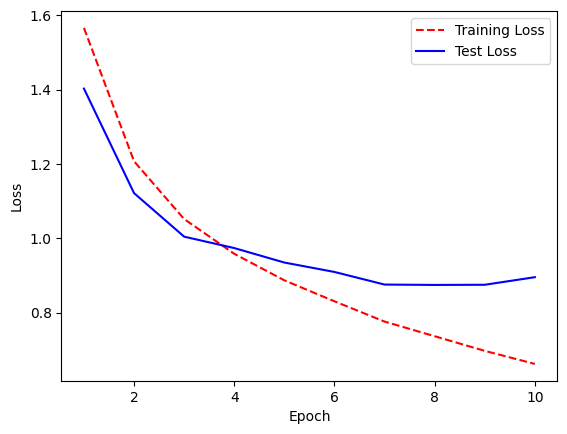

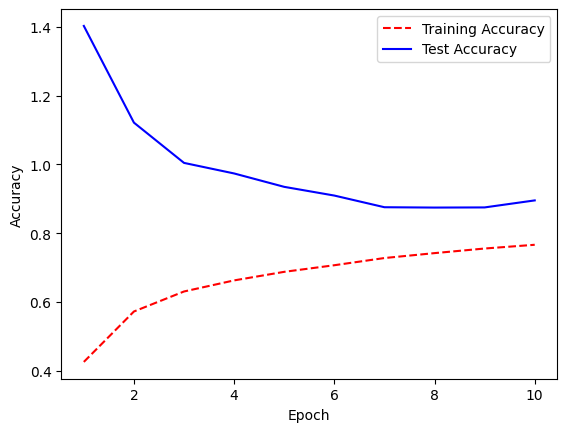

In [ ]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();
